# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
sys.path.append("/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [4]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [5]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [6]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [7]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [8]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 2186.2566179174205 [-1.61143707 -0.14445796  0.33200674  0.30397079]
iteration 1 accepted 1908.5493556930667 [-1.09334411 -0.28951228  0.24040787 -0.13804171]
iteration 2 accepted 1760.510664458551 [-0.65009123 -0.20453685  0.24221019 -0.1587188 ]
iteration 3 accepted 1699.0847641004498 [-0.26028602 -0.1462213   0.22947543 -0.20913305]
iteration 4 accepted 1691.880517076246 [-0.06392953 -0.0592797   0.27199778 -0.14549061]
iteration 5 accepted 1683.3154288131607 [-0.0498577  -0.05147336  0.28064454 -0.13800189]
iteration 6 accepted 1677.5954092335623 [-0.02630468 -0.04182759  0.29554302 -0.12906277]
iteration 7 accepted 1672.4112824443546 [-0.02588116 -0.04161006  0.29653712 -0.12942795]
iteration 8 accepted 1667.1778993185117 [-0.02347531 -0.04238528  0.30225847 -0.13408716]
iteration 9 accepted 1664.1906331304272 [-0.02305698 -0.04169135  0.30148029 -0.13381455]
iteration 10 accepted 1659.385234793443 [-0.02217768 -0.04086552  0.29939752 -0.13345571]
iteration 11

iteration 91 accepted 1514.291603475703 [ 0.00369585 -0.17252944  0.09636993 -0.24669138]
iteration 92 accepted 1513.1221244647543 [ 0.01147996 -0.16228669  0.10128852 -0.23017521]
iteration 93 accepted 1512.6140881658466 [ 0.00759061 -0.17180858  0.09287812 -0.24222639]
iteration 94 accepted 1510.9988443433265 [ 0.00579428 -0.17424229  0.09400419 -0.24544594]
iteration 95 accepted 1510.2489377587815 [ 0.00930851 -0.17358829  0.09135767 -0.24338807]
iteration 96 accepted 1509.3128731179102 [ 0.00950903 -0.17446587  0.09196008 -0.24380776]
iteration 97 accepted 1508.6198337208457 [ 0.01076659 -0.17537558  0.08940176 -0.24384173]
iteration 98 accepted 1507.7331004242749 [ 0.00996034 -0.17672315  0.08974463 -0.24493137]
iteration 99 accepted 1507.0719657853492 [ 0.01021417 -0.17762022  0.08716469 -0.24518477]
iteration 100 accepted 1506.229340617417 [ 0.00893774 -0.17862337  0.08720438 -0.24618673]
iteration 101 accepted 1505.6153292855674 [ 0.00903069 -0.17932182  0.08434997 -0.24652041]

iteration 181 accepted 1468.7669585777098 [ 0.03356214 -0.2816332   0.00694944 -0.37808787]
iteration 182 accepted 1468.493890905124 [ 0.03636034 -0.2815941   0.00913775 -0.37781952]
iteration 183 accepted 1468.4436877462952 [ 0.03720609 -0.28264657  0.00448869 -0.37945308]
iteration 184 accepted 1468.2667014646381 [ 0.03452793 -0.28747107  0.00759569 -0.3866999 ]
iteration 185 accepted 1467.6336871003143 [ 0.03412816 -0.28556321  0.00435757 -0.38433593]
iteration 186 accepted 1467.3563377146977 [ 0.03721828 -0.28533522  0.00671508 -0.38372085]
iteration 187 accepted 1467.3171019270098 [ 0.03796612 -0.2865408   0.00151776 -0.38558561]
iteration 188 accepted 1467.1391906685644 [ 0.03485773 -0.29178188  0.00498065 -0.3933927 ]
iteration 189 accepted 1466.4347152848673 [ 0.03423714 -0.28981067  0.00125083 -0.39094654]
iteration 190 accepted 1466.1097609857864 [ 0.03737187 -0.2894424   0.0040818  -0.38995371]
iteration 191 accepted 1466.0313858475884 [ 0.03794546 -0.29110086 -0.00207051 -0

iteration 271 accepted 1433.764435597063 [ 0.05444128 -0.34205405 -0.03893503 -0.47825469]
iteration 272 accepted 1433.3510052223094 [ 0.05343744 -0.34121024 -0.03275763 -0.47682965]
iteration 273 accepted 1432.8171030076112 [ 0.05393651 -0.34164181 -0.03828951 -0.47707583]
iteration 274 accepted 1432.6217705339259 [ 0.05454216 -0.34495724 -0.03165588 -0.48098791]
iteration 275 accepted 1431.8590441200085 [ 0.05388918 -0.34449385 -0.04003752 -0.48059675]
iteration 276 accepted 1431.6193234378482 [ 0.05373464 -0.34443796 -0.03295401 -0.48038746]
iteration 277 accepted 1431.1764952846013 [ 0.05444421 -0.34421027 -0.03938992 -0.48015951]
iteration 278 accepted 1430.9553646209788 [ 0.05551046 -0.3443062  -0.03361057 -0.48044029]
iteration 279 accepted 1430.6246388063944 [ 0.05626065 -0.34392192 -0.03930923 -0.48012012]
iteration 280 accepted 1430.4136080196438 [ 0.05726721 -0.34389018 -0.03415941 -0.48046047]
iteration 281 accepted 1430.1349187917067 [ 0.05792668 -0.34358021 -0.03935651 -0

iteration 362 accepted 1406.8090056223086 [ 0.05480094 -0.36709116 -0.05042289 -0.52220081]
iteration 363 accepted 1406.448759944369 [ 0.05592544 -0.36442395 -0.05372839 -0.51789632]
iteration 364 accepted 1406.243090090886 [ 0.05886409 -0.36466872 -0.04821553 -0.51688929]
iteration 365 accepted 1405.9876972606876 [ 0.05977636 -0.36429253 -0.05366081 -0.51633206]
iteration 366 accepted 1405.8546459090865 [ 0.0608088  -0.36494124 -0.04788528 -0.51709278]
iteration 367 accepted 1405.5850127948447 [ 0.06125841 -0.36457603 -0.05418992 -0.51674368]
iteration 368 accepted 1405.4907975708009 [ 0.06148786 -0.36505463 -0.04749352 -0.5175932 ]
iteration 369 accepted 1405.1897699720669 [ 0.06176591 -0.36478019 -0.05467472 -0.5174896 ]
iteration 370 accepted 1405.1289359325626 [ 0.06155696 -0.36527243 -0.04724508 -0.51853747]
iteration 371 accepted 1404.7920352715637 [ 0.06175035 -0.36501583 -0.05523383 -0.51854963]
iteration 372 accepted 1404.7621129105908 [ 0.0612649  -0.36548692 -0.04716017 -0.

iteration 452 accepted 1383.2101393281807 [ 0.06205386 -0.37505629 -0.05633579 -0.53611156]
iteration 453 accepted 1383.0799941995224 [ 0.06422535 -0.3749963  -0.06292116 -0.53532599]
iteration 454 accepted 1382.7035728349633 [ 0.06318406 -0.37612056 -0.0559031  -0.53677857]
iteration 455 accepted 1382.6595832704415 [ 0.06419411 -0.37549991 -0.06464478 -0.53584427]
iteration 456 accepted 1382.1448307185265 [ 0.06164425 -0.37773544 -0.05606875 -0.53886414]
iteration 457 converged 1382.144502683048 [ 0.06229968 -0.3760391  -0.06573835 -0.53647501]


In [9]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [10]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

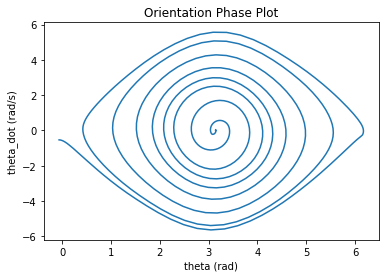

In [11]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")
plt.show()

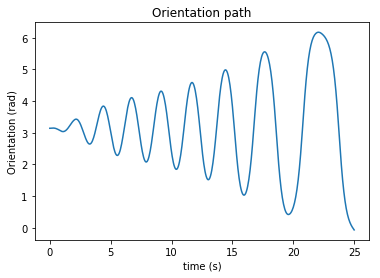

In [12]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

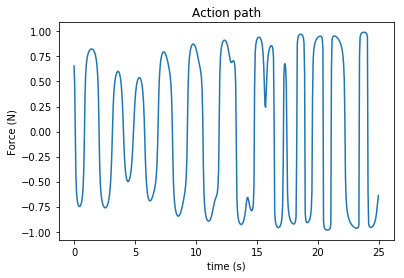

In [13]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

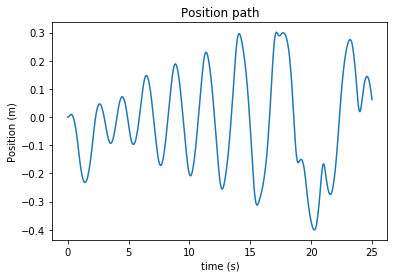

In [14]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

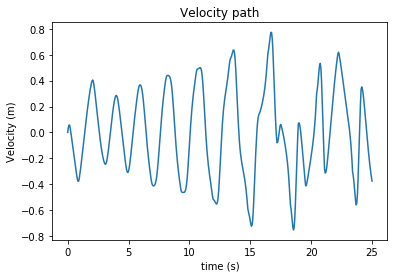

In [15]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

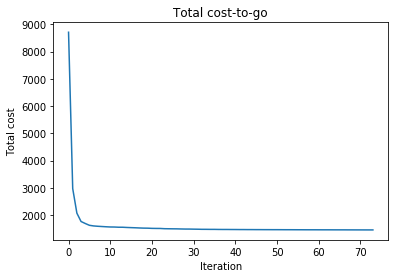

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

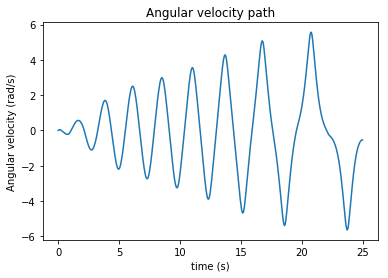

In [16]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")